## Variance partitioning

Completely functional programming approach: out = f(in_1, in_2, ...) -> out

In [ ]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scanpy as sc

# scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Graphics settings
mpl.rcParams['xtick.color'] = 'grey'
mpl.rcParams['ytick.color'] = 'grey'
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['axes.grid'] = False
# mpl.rcParams['xtick.labelsize'] = 10
# mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 15
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.labelcolor'] = 'grey'
mpl.rcParams['font.size'] = 15
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['axes.edgecolor'] = 'grey'
mpl.rcParams['text.color'] = 'grey'
mpl.rcParams['xtick.minor.visible'] = False
mpl.rcParams['ytick.minor.visible'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['legend.loc'] = 'upper left'
mpl.rcParams['figure.constrained_layout.h_pad'] = 0.12
mpl.rcParams['figure.constrained_layout.w_pad'] = 0.12
mpl.rcParams['figure.max_open_warning'] = 200


class GeneralContainer:
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)
            
    def __repr__(self):
        c = (
            '\n\nObject of class:\t' + 
            type(self).__name__ + 
            '\n\n'
        )
        o = self.__dict__
        out = ''        
        for k_, o_ in o.items():
            out += k_ + ':\t' + str(type(o_)) + '\n'  
        o_additional = {}    
        for o_ in dir(self):
            if '__' not in o_ and (o_ not in o.keys()):
                obj = getattr(self, o_)
                o_additional[o_] = str(type(obj))
        out_additional = ''        
        for k_, o_ in o_additional.items():
            out_additional += k_ + ':\t' + repr(o_) + '\n'
        return c + out + out_additional
    
    def add_method(self, func, 
                   delete = True, 
                   return_function = False): 
        '''
        Pass a function and deletes it 
        from the global environment.
        '''
        from functools import wraps
        @wraps(func) 
        def wrapper(*args, **kwargs): 
            return func(*args, **kwargs) 
        setattr(self, func.__name__, wrapper) 
        if delete and func.__name__ in globals().keys():
            del globals()[func.__name__]
        if return_function:
            return getattr(self, func.__name__)


In [81]:
adata_obj = sc.read_h5ad('adata_obj.h5ad')

In [47]:
variation = GeneralContainer()

def construct_design_matrix(adata: sc.AnnData, 
                            vars_: list) -> np.ndarray:
    import sklearn.preprocessing
    
    # Generate full model matrix (can have linearly dependent cols)
    M = adata.obs.loc[:, vars_]
    
    encoder = sklearn.preprocessing.OneHotEncoder(
        drop = 'first', 
        sparse = False
    )
    M = encoder.fit_transform(M)
    M = np.c_[np.ones((M.shape[0], 1)), M]
    
    # remove linearly dependent cols
    M_subset = M[:, [0]] # start with the intercept
    for i in range(2, M.shape[1]):
        M_subset_ = np.c_[M_subset, M[:, i]]
        rank = np.linalg.matrix_rank(M_subset_)
        if rank > M_subset.shape[1]: 
            # update if col isn't linearly dependent
            M_subset = M_subset_
    
    return M_subset

variation.add_method(construct_design_matrix)


def compute_residual_sum_of_squares(Y: np.ndarray, 
                                    Q: np.ndarray,
                                    R: np.ndarray,
                                    M: np.ndarray) -> np.ndarray:
    '''
    Arguments:
        Y (c cells, g genes) # scaled gene expression matrix (adata_obj.X)
        Q (m cells, f design features)
        R (f design features, f design features)
        M (m cells, f design features)

    Intermediates:
        B (f design features, g genes) # coeffcients
        Y_pred (c cells, g genes) # same shape as Y
        res (c cells, g genes) # same shape as Y

    Returns:
        res_ss (g genes)
    '''
    B = np.linalg.inv(R).dot(Q.T).dot(Y)
    Y_pred = M.dot(B)
    res = Y - Y_pred
    res_ss = np.linalg.norm(res, ord = 2, axis = 0) ** 2
    return res_ss
        
variation.add_method(compute_residual_sum_of_squares)   



def variables_looper(adata: sc.AnnData, 
                     vars_: list) -> pd.DataFrame:
    # initializations
    n_vars = len(vars_)
    n_obs = adata.X.shape[1]
    vars_sum_of_squares = np.zeros((n_obs, n_vars))
    Y = adata.X
    # full model sum_of_squares
    M = variation.construct_design_matrix(adata, vars_)
    Q, R = np.linalg.qr(M)
    full_model_sum_of_squares = (
        variation
        .compute_residual_sum_of_squares(Y, Q, R, M)
    )
    # model without 1 term at a time sum_of_squares
    for i, var in enumerate(vars_):
        vars_no_i = [var_ for var_ in vars_ if var_ != var]
        M = variation.construct_design_matrix(adata, vars_no_i)
        Q, R = np.linalg.qr(M)
        vars_sum_of_squares[:, i] = (
            variation
            .compute_residual_sum_of_squares(Y, Q, R, M)
        )
        vars_sum_of_squares[:, i] -= full_model_sum_of_squares
    # concluding actions
    vars_sum_of_squares = pd.DataFrame(
        vars_sum_of_squares,
        columns = vars_,
        index = adata.var_names
    )
    return vars_sum_of_squares

variation.add_method(variables_looper)

In [48]:
%%time

variation.vars_sum_of_squares = variation.variables_looper(
    adata_obj, 
    [
        'chipwell', 
        'gene_edit',
        'original_donor_id',
        'cell_cycle_phase'
    ]
)

CPU times: user 35min 26s, sys: 6min 19s, total: 41min 45s
Wall time: 3min 27s


In [49]:
variation.vars_sum_of_squares

,chipwell,gene_edit,original_donor_id,cell_cycle_phase
ensembl_id,,,,
ENSG00000188290,2516.420758,10629.602744,1700.253712,2092.768772
ENSG00000131591,668.603807,304.955399,369.082418,9771.936016
ENSG00000186891,10945.344171,15982.967415,9472.808200,30068.464436
ENSG00000186827,19274.926004,7846.860724,10764.558607,20023.089008
ENSG00000215790,289.408366,264.638439,595.366741,97.156766
...,...,...,...,...
ENSG00000165246,486.313925,1772.475235,22146.510005,1138.157212
ENSG00000176728,73.275925,1253.182252,17708.324057,465.614320
ENSG00000228253,56459.558965,4123.309458,6918.958867,7547.409551


In [50]:
def calculate_minimal_model_sum_of_squares(adata: sc.AnnData) -> np.ndarray:
    '''
    This model doens't have to be solved with the wrokflow 
    used for the variables as mathematically all needs to be 
    done is Tot_ss = (y - mean(y)).dot(y - mean(y)) for each 
    gene, or in other words: sum((y - mean(y)^2)).
    On the other hand, using the same workflow provides a very
    intuitive way to compare where these sum of squares come
    from.
    '''
    Y = adata.X
    M = variation.construct_design_matrix(adata, []) # model matrix with just intercept
    Q, R = np.linalg.qr(M)
    minimal_model_sum_of_squares = (
        variation
        .compute_residual_sum_of_squares(Y, Q, R, M)
    )
    return minimal_model_sum_of_squares

variation.add_method(calculate_minimal_model_sum_of_squares)

variation.minimal_model_sum_of_squares = (
    variation
    .calculate_minimal_model_sum_of_squares(adata_obj)
)

In [51]:
def calculate_fraction_sum_of_squares(minimal_model_sum_of_squares: pd.DataFrame, 
                                      vars_sum_of_squares: pd.DataFrame) -> pd.Series:
    
    total_sum_of_squares = (
        minimal_model_sum_of_squares
        .sum()
    )
    vars_sum_of_squares = (
        vars_sum_of_squares
        .sum(0)
        .sort_values()
    )# pd.Series
    vars_fraction_of_squares = (
        vars_sum_of_squares / 
        total_sum_of_squares
    ) # pd.Series
    return vars_fraction_of_squares

variation.add_method(calculate_fraction_sum_of_squares)

variation.vars_fraction_of_squares = (
    variation
    .calculate_fraction_sum_of_squares(
        variation.minimal_model_sum_of_squares, 
        variation.vars_sum_of_squares
    )
)

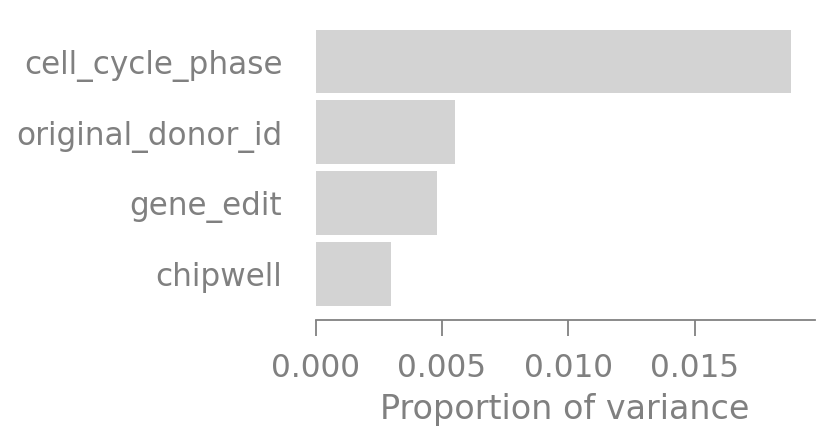

In [52]:
def plot_scores(vars_fraction_of_squares: pd.Series) -> None:
    fig, ax = plt.subplots(1, 1, figsize = (4, 2.5))
    y = np.arange(len(vars_fraction_of_squares))
    plt.barh(
        y = y, 
        width = vars_fraction_of_squares.values,
        height = 0.9, 
        color = 'lightgrey'
    )
    ax.set_yticks(y, labels = vars_fraction_of_squares.index)
    ax.spines['left'].set_visible(False)
    ax.tick_params(left = False)
    ax.set_xlabel('Proportion of variance')
    
    
variation.add_method(plot_scores)
variation.plot_scores(variation.vars_fraction_of_squares)